In [325]:
import pandas as pd
#from sklearn.naive_bayes import MultinomialNB

In [326]:
# Load data
data = pd.read_csv('https://otf.ca/sites/default/files/OTF-Grants_since2000.csv')

In [327]:
data = data.drop(columns=['Funding Org:Org subventionnaire', 'Country Served:Pays servis', 'Province Served:Province servis', 'Cross-catchment indicator:Indicateur interrégional', 'Co-Application:Co-demandeurs', 'Description (French/Français)', 'Grant Result:Résultat de subvention','Rescinded/Recovered:Révoqué/récupéré','Rescinded/Recovered Initiated By:Révoqué/récupéré intié par','Amount Rescinded/Recovered:Montant révoqué/récupéré', 'Last modified:Mise à jour'])
data.columns = ['fiscal_year','grant_program','geographical_area','identifier','org_name','submission_date', 'approval_date', 'amount_applied', 'amount_awarded', 'planned_duration', 'description', 'program_area', 'budget_fund', 'org_incorporation_num', 'org_charitable_reg_num', 'org_city', 'org_postcode', 'population_served', 'age_group']

In [328]:
description = pd.DataFrame(data, columns = ['description'])

In [329]:
# remove structured text and keep only free-form text
a = description['description'].str.split('programs for Ontarians by ').str[1].dropna()
b = description['description'].str.split('grant over \d+ years to ').str[1].dropna()
c = description['description'].str.split('rebuild and recover from impacts of COVID-19 by ').str[1].dropna()
d = description['description'].str.split('grant over \d+ months to ').str[1].dropna()
e = description['description'].str.split('\$\d+( \w+|[\d,]+) over \d+ months to ').str[2].dropna()
f = description['description'].str.split('\$\d+( \w+|[\d,]+) over one year to ').str[2].dropna()
g = description['description'].str.split('\$\d+( \w+|[\d,]+) over two years to ').str[2].dropna()
h = description['description'].str.split('\$\d+( \w+|[\d,]+) over three years to ').str[2].dropna()
i = description['description'].str.split('\$\d+( \w+|[\d,]+) over six months to ').str[2].dropna()
j = description['description'].str.split('This project aims to ').str[1].dropna()

In [330]:
description_clean = pd.concat([a, b, c, d, e, f, g, h, i, j], axis=0,ignore_index=False)
description_clean = description_clean.to_frame()

In [331]:
add_indices = pd.Index(range(27952)).difference(description_clean.index)
add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
description_clean = pd.concat([description_clean, add_df])

In [332]:
#from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = CountVectorizer(ngram_range=(1,1), min_df = 50, max_df = 0.95, stop_words='english')
#counts_sparse = vectorizer.fit_transform(description_clean['description'])
#counts = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
#counts

In [333]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 300, stop_words = 'english')
counts_sparse = vectorizer.fit_transform(description_clean['description'])
counts = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
counts = counts.drop(counts.columns[0:11], axis=1) 

In [334]:
counts.shape

(27953, 289)

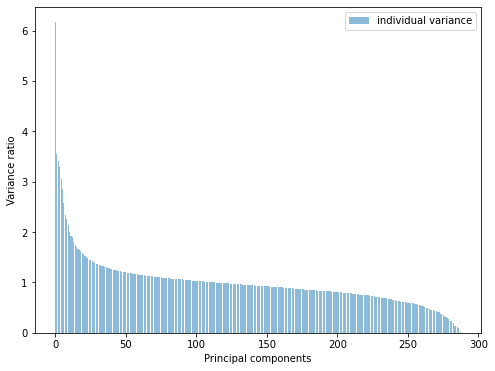

In [335]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
enconder = LabelEncoder()

for col in counts.columns:
    counts[col] = enconder.fit_transform(counts[col])
    
counts_features = counts.iloc[:,1:289]
counts_label = counts.iloc[:,0]

scaler = StandardScaler()
counts_features = scaler.fit_transform(counts_features)
    
pca = PCA()
pca.fit_transform(counts_features)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(288), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

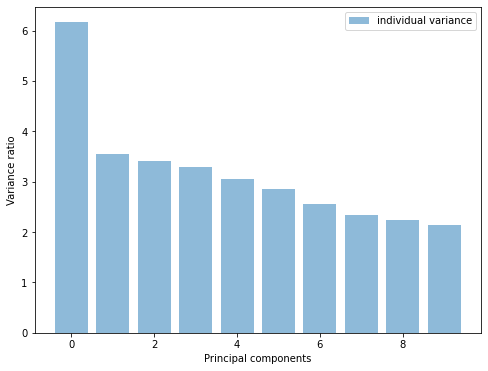

In [336]:
pca2 = PCA(n_components=10)
pca2.fit(counts_features)
counts_reduced = pca2.transform(counts_features)

pca_variance2 = pca2.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(10), pca_variance2, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()


In [337]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [338]:
#inertia_list = []
#for k in range(2,10):
#    model = KMeans(n_clusters=k)
#    model.fit(counts)
#    cluster_id = pd.Series(model.predict(counts))
#    inertia_list.append({'k':k, 'inertia':model.inertia_})
#
#ax = pd.DataFrame(inertia_list).set_index('k').plot.line()
#ax.set_ylabel('inertia (WSS)')

In [341]:
sil_scores = []
for k in range(3,9):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(counts)
    label = clusterer.predict(counts)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(counts, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label']
best_label

# Present some summary statistics for each clusters
pd.DataFrame(counts).groupby(best_label).mean()

,abilities,able,aboriginal,access,accessibility,accessible,active,activities,activity,additional,...,website,wellbeing,women,work,workshops,year,years,york,young,youth
0,4.027094,3.625930,1.786260,58.672786,6.353008,35.519008,6.952832,66.932498,10.246243,2.821988,...,4.448333,0.284050,13.727027,13.330074,14.468667,54.959332,66.027719,4.122575,16.525664,402.356493
1,6.275245,4.435439,0.984171,82.970101,11.214568,65.972006,12.437491,105.819581,11.171039,1.918804,...,2.206214,2.850799,6.902829,15.206214,9.429430,59.080756,48.752895,4.277444,10.195369,226.825150
2,1.003156,12.352972,0.089427,29.047344,3.775907,39.701736,132.739611,96.415571,13.099947,0.192530,...,0.048396,55.709100,3.722777,2.397685,3.330878,2.601789,1.185692,0.712783,6.217780,264.872699


In [342]:
sil_scores = []
for k in range(3,9):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(counts_reduced)
    label = clusterer.predict(counts_reduced)
    sil_scores.append({'k':k, 'silhouette_score':silhouette_score(counts_reduced, label), 'label':label})

# Select best labels (based on silhouette score)
sil_scores = pd.DataFrame(sil_scores)
best_label = sil_scores.loc[sil_scores['silhouette_score'].idxmax(),'label']
best_label

# Present some summary statistics for each clusters
pd.DataFrame(counts_reduced).groupby(best_label).mean()

,0,1,2,3,4,5,6,7,8,9
0,7.717719,0.397291,-0.609481,4.131650,0.208360,0.361026,2.408230,-0.931009,-0.659538,0.221754
1,4.983199,2.230347,9.129778,-2.519421,0.742613,0.460178,-1.500781,0.240016,-0.017527,0.702032
2,8.715763,-3.984873,-3.556345,-6.283369,-3.058717,-1.801610,-2.002500,-0.394763,0.541968,-0.170681
3,2.074562,5.808189,-4.112471,-3.202082,6.801602,1.781180,-0.576607,0.591262,1.941959,1.458933
4,-0.702734,-0.109004,-0.036033,0.084887,-0.104764,-0.025758,-0.013428,0.031529,-0.023245,-0.054554


In [ ]:
#pd.DataFrame(x).to_csv('x.csv', index=True, header=False)

In [156]:
#pd.DataFrame(description).to_csv('desc.csv', index=True, header=False)

In [ ]:
#model = KMeans(n_clusters=6)
#model.fit(counts)
#assignments = pd.Series(model.predict(counts))
#ax = counts.plot.scatter(0, 1, 3)

In [89]:
# Split data for classif
#training = featured.head(22360)
#testing = featured.tail(5593)
#holdout = training.groupby('grant_program', group_keys=False).apply(lambda x: x.sample(frac=0.2, random_state=3))
#training = training.drop(holdout.index)